In [2]:
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, roc_auc_score, precision_recall_curve
from scipy.stats import uniform, randint
from imblearn.over_sampling import ADASYN
from collections import Counter

# Ensure plots are displayed within the notebook
%matplotlib inline


In [3]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Pima_dataset = pd.read_csv(url, header=None, names=column_names)


In [4]:
Pima_dataset.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
print("Analysing Original Data Distribution")
print("------------------------------------")

# Check for missing values or zero values
print("Null values in features")
print(Pima_dataset.isnull().sum())
print()
print("Zero values in features")
print("Glucose                   {0}".format(len(Pima_dataset.loc[Pima_dataset['Glucose'] == 0])))
print("BloodPressure             {0}".format(len(Pima_dataset.loc[Pima_dataset['BloodPressure'] == 0])))
print("Skin thickness            {0}".format(len(Pima_dataset.loc[Pima_dataset['SkinThickness'] == 0])))
print("Insulin                   {0}".format(len(Pima_dataset.loc[Pima_dataset['Insulin'] == 0])))
print("BMI                       {0}".format(len(Pima_dataset.loc[Pima_dataset['BMI'] == 0])))
print("DiabetesPedigreeFunction  {0}".format(len(Pima_dataset.loc[Pima_dataset['DiabetesPedigreeFunction'] == 0])))
print("Age                       {0}".format(len(Pima_dataset.loc[Pima_dataset['Age'] == 0])))

# # Visualize data distribution
# sns.pairplot(data, hue='Outcome')
# plt.show()


Analysing Original Data Distribution
------------------------------------
Null values in features
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Zero values in features
Glucose                   5
BloodPressure             35
Skin thickness            227
Insulin                   374
BMI                       11
DiabetesPedigreeFunction  0
Age                       0


In [6]:
imputer = SimpleImputer(strategy='mean', missing_values=0)
imputer = imputer.fit(Pima_dataset[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']])
Pima_dataset[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = imputer.transform(Pima_dataset[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']])


In [7]:
print("Verifying no Zero values left in features after mean imputing")
print("Glucose                   {0}".format(len(Pima_dataset.loc[Pima_dataset['Glucose'] == 0])))
print("BloodPressure             {0}".format(len(Pima_dataset.loc[Pima_dataset['BloodPressure'] == 0])))
print("Skin thickness            {0}".format(len(Pima_dataset.loc[Pima_dataset['SkinThickness'] == 0])))
print("Insulin                   {0}".format(len(Pima_dataset.loc[Pima_dataset['Insulin'] == 0])))
print("BMI                       {0}".format(len(Pima_dataset.loc[Pima_dataset['BMI'] == 0])))
print("DiabetesPedigreeFunction  {0}".format(len(Pima_dataset.loc[Pima_dataset['DiabetesPedigreeFunction'] == 0])))
print("Age                       {0}".format(len(Pima_dataset.loc[Pima_dataset['Age'] == 0])))

Verifying no Zero values left in features after mean imputing
Glucose                   0
BloodPressure             0
Skin thickness            0
Insulin                   0
BMI                       0
DiabetesPedigreeFunction  0
Age                       0


<Axes: >

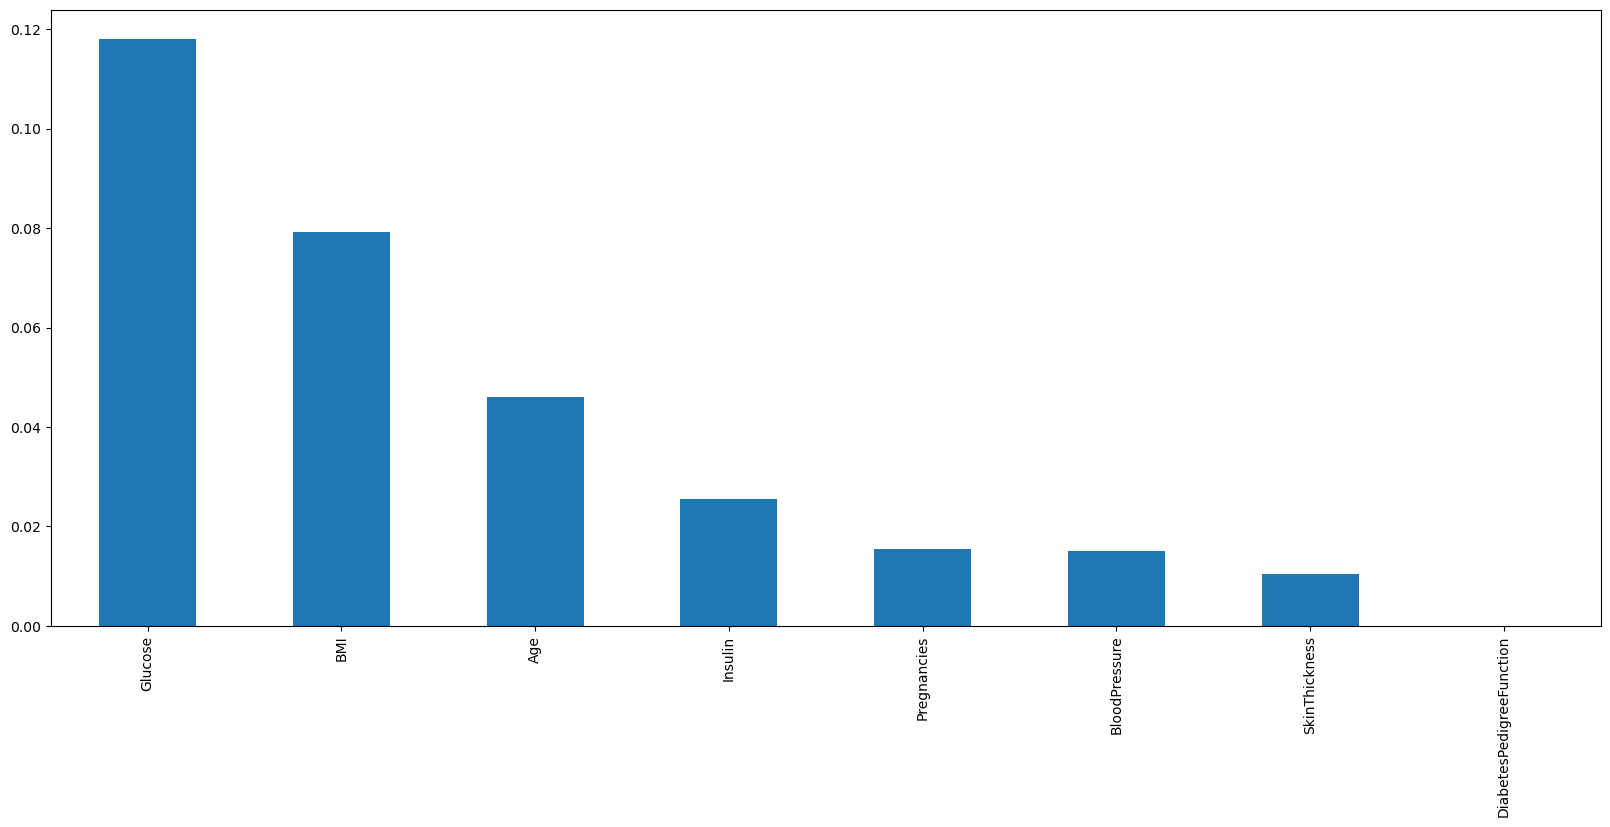

In [8]:
# Separate features and target
X = Pima_dataset.drop(columns='Outcome', axis=1)
y = Pima_dataset['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
mutual_info = pd.Series(mutual_info_classif(X_train, y_train, random_state = 0))
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending = False)
plt.figure(figsize = (20, 8))
mutual_info.sort_values(ascending = False).plot.bar()

In [9]:
print("Dropping DPF i.e. features not related to outcome")
Pima_dataset.drop(columns='DiabetesPedigreeFunction',axis=1, inplace=True)

Dropping DPF i.e. features not related to outcome


In [10]:
print("Predicting Insulin values for RTML Dataset (to be merged with PIMA) using XGBoost")
X = Pima_dataset.drop(columns='Insulin', axis=1)
y = Pima_dataset['Insulin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
XGB = XGBRegressor(max_depth=10,learning_rate=0.1)
XGB.fit(X_train,y_train)
predictions_xgb = XGB.predict(X_test)
final_mse = mean_squared_error(y_test, predictions_xgb)
final_rmse = np.sqrt(final_mse)
print("Insulin Regressor RMSE score:", final_rmse)

Predicting Insulin values for RTML Dataset (to be merged with PIMA) using XGBoost
Insulin Regressor RMSE score: 85.79124540997681


In [11]:
RTML_dataset = pd.read_excel('RTML without Insulin.xlsx')
print("Null values in features")
RTML_dataset.isna().sum()
print("Replacing Null Insulin feature from RTML with Predicted values")
X1 = RTML_dataset.drop(columns='Insulin', axis=1)
Y1 = XGB.predict(X1)
Y2= pd.DataFrame(Y1)
Y2.columns=['Insulin']
RTML_dataset.drop(columns='Insulin',axis=1, inplace=True)
Insulin_Merged = pd.concat([RTML_dataset, Y2], axis=1)
RTML_Merged = Insulin_Merged[["Pregnancies", "Glucose", "BloodPressure","SkinThickness","Insulin", "BMI", "Age","Outcome"]]
RTML_Merged.head

Null values in features
Replacing Null Insulin feature from RTML with Predicted values


<bound method NDFrame.head of      Pregnancies  Glucose  BloodPressure  SkinThickness     Insulin  \
0              5     88.2          106.0            4.8  204.799011   
1              6     73.8           74.0            7.5  211.457794   
2              1     86.4           87.0           18.4  119.480362   
3              1     97.2           71.0           15.0   67.878632   
4              5     90.0           96.0            7.6  220.453064   
..           ...      ...            ...            ...         ...   
104            3    187.2           79.0            9.4  177.282700   
105            2    149.4           82.0            9.8  218.581390   
106            1    163.8           84.0            6.5  192.582047   
107            4    167.4           86.0           11.7  242.816025   
108            2    171.0           78.0           10.8  189.431580   

           BMI  Age  Outcome  
0    14.794213   50        0  
1    24.851410   50        0  
2    41.621307   30     

In [12]:
print("Merging RTML with PIMA")
pieces = {"x": Pima_dataset, "y": RTML_Merged}
data = pd.concat(pieces)
print("Number of samples and features:", data.shape)

Merging RTML with PIMA
Number of samples and features: (877, 8)


In [13]:
# def detect_outliers_z_score(feature, threshold=3):    # outputs a list of values which are outliers for that feature
#     z_scores = np.abs((feature - feature.mean()) / feature.std())
#     outliers = np.where(z_scores > threshold)    # how does it store the actual value instead of normalized in the outliers list?
#     return outliers

# # Detect outliers for each feature using Z-score
# z_score_outliers = {}
# for column in X.columns:
#     outliers = detect_outliers_z_score(X[column])
#     z_score_outliers[column] = outliers[0]

# # Display the outliers
# for column, outliers in z_score_outliers.items():
#     print(f"Outliers in {column}: {outliers}")

# def detect_outliers_iqr(data, threshold=1.5):
#     Q1 = data.quantile(0.25)
#     Q3 = data.quantile(0.75)
#     IQR = Q3 - Q1
#     outliers = data[((data < (Q1 - threshold * IQR)) | (data > (Q3 + threshold * IQR)))]    # What logic?
#     return outliers

# # Detect outliers for each feature using IQR
# iqr_outliers = {}
# for column in X.columns:
#     outliers = detect_outliers_iqr(X[column])
#     iqr_outliers[column] = outliers

# # Display the outliers
# for column, outliers in iqr_outliers.items():
#     print(f"Outliers in {column}: {outliers.index.tolist()}")    # why so much processing needed?

def remove_outliers_iqr(df,threshold=1.5):
    # Identify columns with numerical data
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Filter the dataframe to remove outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Remove outliers using IQR
threshold = 1.5
data = remove_outliers_iqr(pd.DataFrame(data), threshold)
print(f"Number of samples and features after outliers removal using IQR(threshold = {threshold:.2f}):", data.shape)

Number of samples and features after outliers removal using IQR(threshold = 1.50): (698, 8)


In [14]:
# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Apply ADASYN
ada = ADASYN(random_state=0,sampling_strategy='minority')
X_resampled, y_resampled = ada.fit_resample(X, y)

# Normalize features
X_scaled = StandardScaler().fit_transform(X_resampled)

# Check original class distribution
print("Original class distribution:")
print(y.value_counts())
print()

# Check new class distribution
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())
print()

# Verify the number of rows before and after SMOTE
print(f"Number of rows before ADASYN: {X.shape[0]}")
print(f"Number of rows after ADASYN: {X_resampled.shape[0]}")

Original class distribution:
Outcome
0    488
1    210
Name: count, dtype: int64

Class distribution after SMOTE:
Outcome
1    512
0    488
Name: count, dtype: int64

Number of rows before ADASYN: 698
Number of rows after ADASYN: 1000


In [15]:
# Spliting Data into Training and Testing sets using Stratify 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size = 0.20, random_state = 42, stratify=y_resampled)

Best Hyperparameters: {'criterion': 'friedman_mse', 'learning_rate': 0.13687026894027277, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 13, 'n_estimators': 779, 'subsample': 0.9942601816442402}
Best Cross-validation Score: 0.81875
Cross-validation Score: 83.79999999999998 +/- 3.4583232931581156 %
Precision: 0.8387539416132642
Recall: 0.835
F1-score: 0.8343155248271528
AUPRC: 0.913768112357054
ROC AUC: 0.9218687474989996


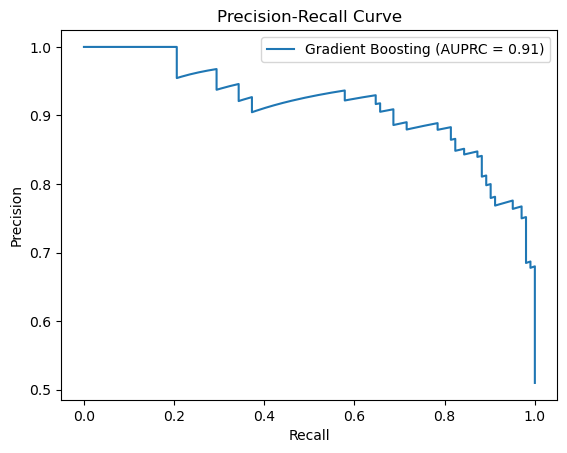

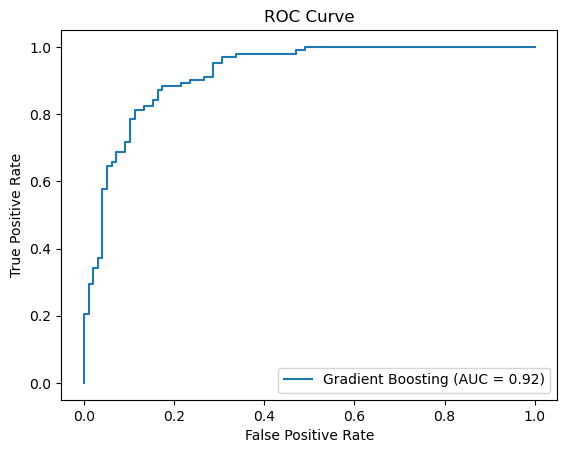

In [16]:

# Gradient Boosting
model = GradientBoostingClassifier(random_state=23)

# Define the parameter distribution
param_dist = {
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(50, 1000),
    'min_samples_split': randint(2, 32),
    'min_samples_leaf': randint(1, 16),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['friedman_mse', 'squared_error']
}

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the random search
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-validation Score:", random_search.best_score_)

# Evaluate the model using K-fold cross-validation with the best hyperparameters
best_model = random_search.best_estimator_
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_scaled, y_resampled, cv=skf, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation Score:", (cv_scores.mean() *100), "+/-", (cv_scores.std()*100), "%")

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

# Precision-Recall Curve and AUPRC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
auprc = auc(recall_curve, precision_curve)
print("AUPRC:", auprc)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall_curve, precision_curve, label=f'Gradient Boosting (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()
